# EDA Analysis

### Welcome to my exploratory data analysis (EDA) of a company we're analyzing. We are trying to determine some trends and discover insights into some aspects of this data.

First, let's import the libraries we'll need, such as Pandas, Numpy, Matplotlib, and Seaborn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Next, let's read the Regional Sales Dataset.xlsx Excel spreadsheet, placing each individual tab therein into a separate dataframe.

In [2]:
sales_df = pd.read_excel("Regional Sales Dataset.xlsx", sheet_name = "Sales Orders")
customers_df = pd.read_excel("Regional Sales Dataset.xlsx", sheet_name = "Customers")
regions_df = pd.read_excel("Regional Sales Dataset.xlsx", sheet_name = "Regions")
states_df = pd.read_excel("Regional Sales Dataset.xlsx", sheet_name = "State Regions")
products_df = pd.read_excel("Regional Sales Dataset.xlsx", sheet_name = "Products")
budgets_df = pd.read_excel("Regional Sales Dataset.xlsx", sheet_name = "2017 Budgets")

In [3]:
# Let's print each of these to make sure we've created these dataframes correctly.

# print(sales_df.head())
# print(customers_df.head())
# print(regions_df.head())
# print(states_df.head())
# print(products_df.head())
# print(budgets_df.head())

In the **sales_df** dataframe, let's change the column name of "Line Total" to "Sales". Labelling this as "Sales" makes more sense and is generally much more understandable.

In [4]:
sales_df = sales_df.rename(columns = {'Line Total': 'Sales'})

# states_df.head()

Let's inner-merge sales with regions and states to perform EDA on sales by states and regions.

In [5]:
sales_states_df = (
    sales_df
    .merge(regions_df[['id', 'state_code']], 
           left_on='Delivery Region Index', right_on='id', how='inner')
    .merge(states_df.rename(columns={"State Code": "state_code"}), 
           on="state_code", how="inner")
)

# print(sales_states_df.head())

Let's add both Year and Month columns to our newly merged **sales_states_df** dataset.

In [6]:
sales_states_df['Year'] = sales_states_df['OrderDate'].dt.year
sales_states_df['Month'] = sales_states_df['OrderDate'].dt.month

Let's also omit any entries from **sales_states_df** with the year 2018 since that is an incomplete year. This will help us better compare the complete years we do have.

In [7]:
sales_states_df = sales_states_df[sales_states_df['Year'] != 2018]

Now let's create a new dataframe **grouped_sales_month_year**, which will group Sales by month.
We'll also create a new Year-Month column which concatenates the Year column, a dash (-), and the Month column.

In [8]:
grouped_sales_month_year = sales_states_df.groupby(['Year','Month'])['Sales'].sum().reset_index()
grouped_sales_month_year['Year-Month'] = grouped_sales_month_year['Year'].astype(str) + '-' + grouped_sales_month_year['Month'].astype(str)
# print(grouped_sales_month_year)

Let's plot this new grouped dataframe so we can spot any trends in Sales over time.

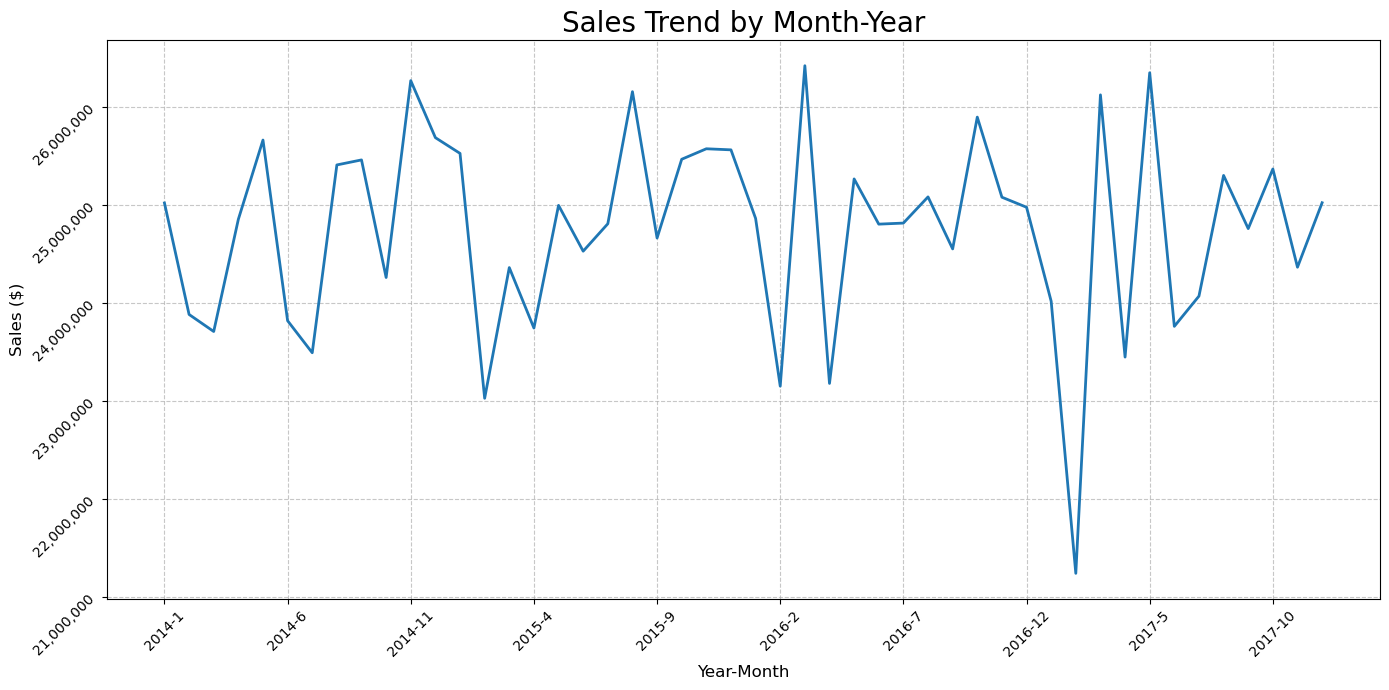

In [9]:
# Set the figure size for better readability
plt.figure(figsize=(14, 7))

# Check if grouped_sales_month_year is a Series and convert if needed
if isinstance(grouped_sales_month_year, pd.Series):
    # Reset the index to turn the date index into a column
    grouped_sales_month_year = grouped_sales_month_year.reset_index()
    # Rename columns if needed - adjust these names to match your actual data
    grouped_sales_month_year.columns = ['Year-Month', 'Sales']

# Create a line chart
plt.plot(grouped_sales_month_year['Year-Month'], grouped_sales_month_year['Sales'], 
         linestyle='-', linewidth=2)

# Add labels and title
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.title('Sales Trend by Month-Year', fontsize=20)

# Format the x-axis to show dates nicely
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))  # Limit number of x-ticks for readability

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Tilt the y-axis labels 45 degrees
plt.yticks(rotation=45)
# Add data labels if the chart isn't too crowded
if len(grouped_sales_month_year) <= 24:  # Only add labels if 24 or fewer points
    for x, y in zip(grouped_sales_month_year['Year-Month'], grouped_sales_month_year['Sales']):
        plt.annotate(f'{y:,.1f}', 
                    (x, y),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

Over time, it appears sales have remained mostly consistent, neither making any long-term trends upward or downward.
It does appear that, during the winter months, January and February especially, in some years, there are temporary decreases, but these rebound quickly the next month.

Now let's group the Sales by region and year so we can see whether the costs remain consistent across each region each year.

In [10]:
sales_states_by_region_year = sales_states_df.groupby(['Region', 'Year'])['Sales'].sum().reset_index()

In [11]:
# print(sales_states_by_region_year)

Let's visualize this with a grouped bar chart denoting Year on the x-axis and amount of Sales on the y-axis,
with each region denoted by a different color bar.

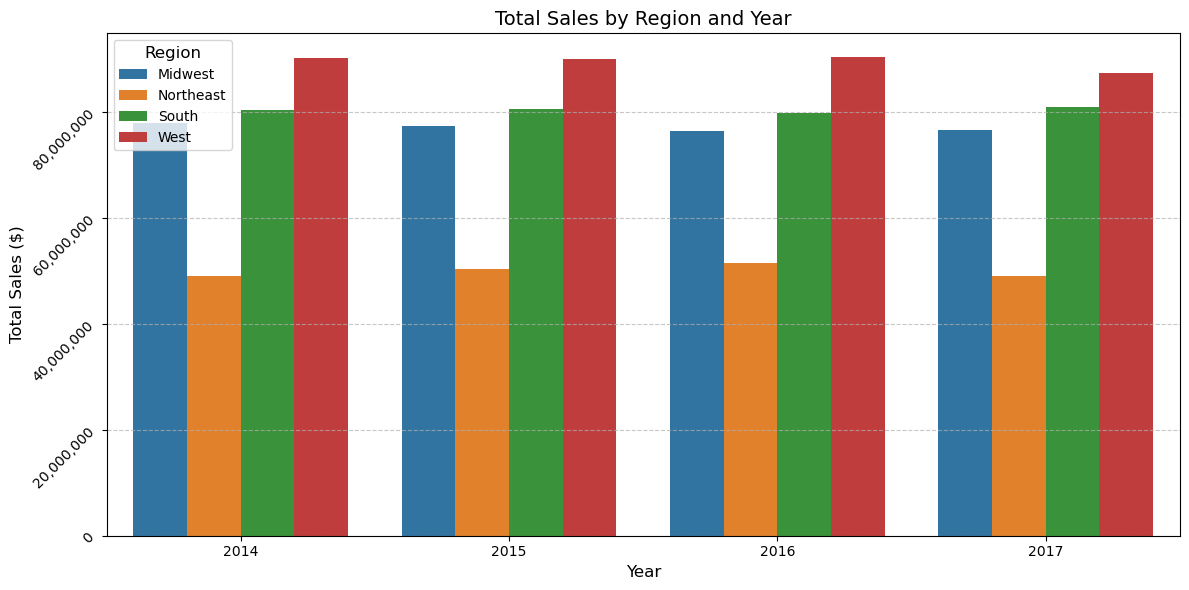

In [12]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create the grouped bar chart
# x-axis: Year, y-axis: Sales, groups: Region
sns.barplot(x='Year', y='Sales', hue='Region', data=sales_states_by_region_year)

# Add title and labels
plt.title('Total Sales by Region and Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)

# Tilt y-axis labels 45 degrees
plt.yticks(rotation=45)

# Enhance the legend
plt.legend(title='Region', title_fontsize=12)

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Add grid lines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Interestingly, the Total Sales are consistent across each year and warehouse, and consistent accross each warehouse relative to other warehouses.

Now let's group the Sales by state, limiting to the top 5 states.
Let's also round the Sales to two (2) decimal places.

In [13]:
grouped_sales_state = sales_states_df.groupby('State')['Sales'].sum().reset_index()
grouped_sales_state = grouped_sales_state.sort_values('Sales', ascending=False).head(5)
grouped_sales_state['Sales'] = grouped_sales_state['Sales'].round(2)
# print(grouped_sales_state)

Now let's visualize this newly grouped dataframe to see the states with the most sales.

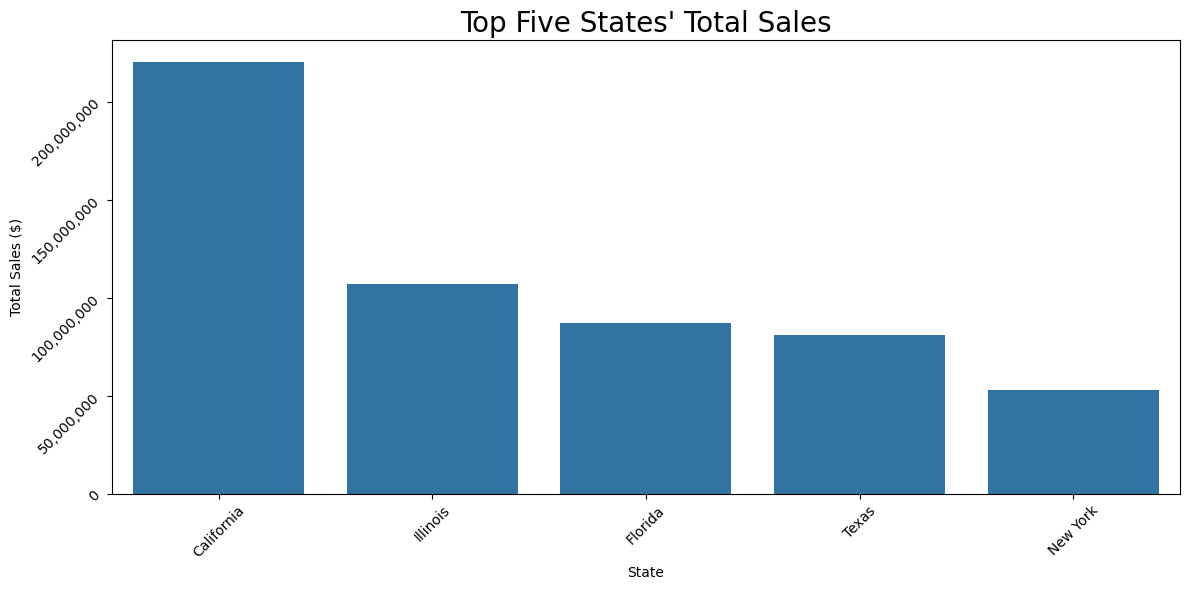

In [14]:
# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Convert the Series to a DataFrame if it's a Series
if isinstance(grouped_sales_state, pd.Series):
    # Reset the index to turn the index into a column
    grouped_sales_state = grouped_sales_state.reset_index()
    # Rename columns if needed - adjust these names to match your actual data
    grouped_sales_state.columns = ['State', 'Sales']

# Create a bar plot using seaborn for better aesthetics
ax = sns.barplot(x='State', y='Sales', data=grouped_sales_state)

# Add labels and title
plt.xlabel('State')
plt.ylabel('Total Sales ($)')
plt.title("Top Five States' Total Sales", fontsize=20)

# Rotate x-axis labels if there are many states
plt.xticks(rotation=45)

# Rotate y-axis labels as well
plt.yticks(rotation=45)

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

With these states generating the most sales, is this possibly because they have a lot of population?

Let's create a **states_by_population** dataframe then visualize it so that we can find this out.

In [15]:
states_by_population = regions_df.groupby('state')['population'].sum().reset_index()
states_by_population = states_by_population.sort_values('population', ascending=False).head(5)

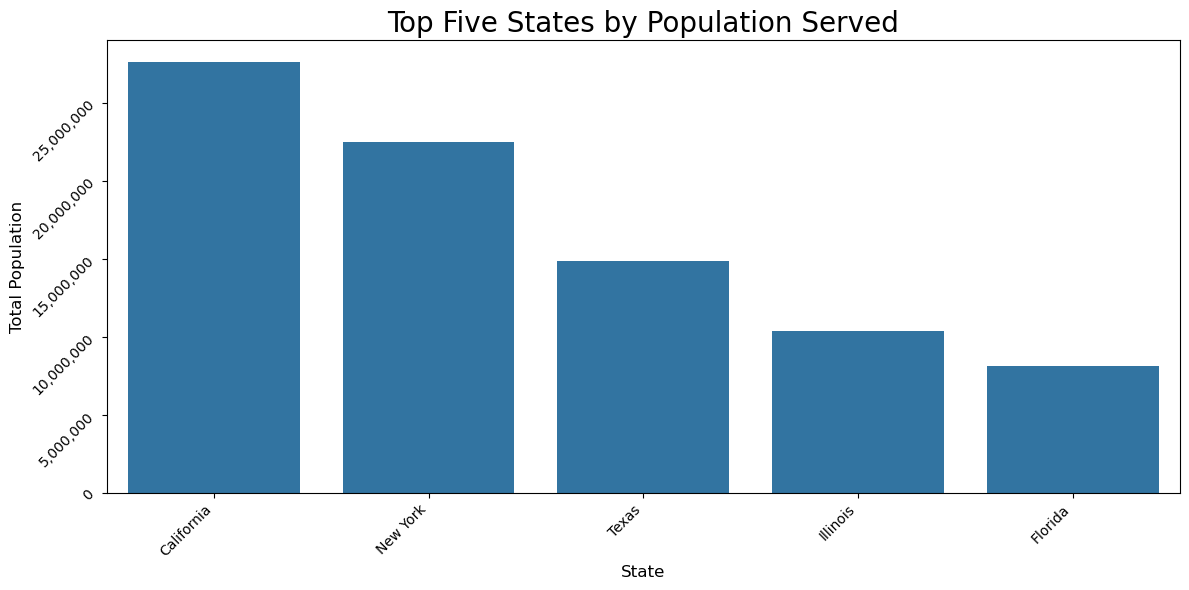

In [16]:
# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create a bar plot with the grouped data
# No error bars and no edge color
sns.barplot(x='state', y='population', data=states_by_population, errorbar=None, edgecolor='none')

# For older versions of seaborn (before v0.12.0), use this alternative:
# ax = sns.barplot(x='state', y='population', data=grouped_df, ci=None, edgecolor='none')

# Add title and labels
plt.title('Top Five States by Population Served', fontsize=20)
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Population', fontsize=12)

# Tilt y-axis labels 45 degrees
plt.yticks(rotation=45)

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Rotate x-axis labels for better readability if there are many states
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Indeed, all five states that topped the sales chart also top the population chart (by population served). Presumably, we are getting all these sales because these are huge markets!

Before proceeding any further, let's add a Year column to our original sales_df dataframe, then omit any rows with the year 2018. 2018 is only a partial year in this dataset, so we will eliminate it in order to perform a consistent analysis.

In [17]:
sales_df['Year'] = sales_df['OrderDate'].dt.year
sales_df = sales_df[sales_df['Year'] != 2018]
# print(sales_df.tail())

Now let's group the **regions_df** dataframe by county, summing population, so we can see where these counties are. Let's visualize this to see if any particular regions stick out.

In [18]:
counties_grouped = regions_df.groupby(['county', 'state'])['population'].sum().reset_index()
counties_grouped = counties_grouped.sort_values('population', ascending=False).head(10)
counties_grouped

,county,state,population
349,Richmond County/Queens County/Kings County/New...,New York,8550405
240,Los Angeles County,California,8219148
253,Maricopa County,Arizona,3546258
91,Cook County,Illinois,3013111
92,Cook County/DuPage County,Illinois,2795239
364,San Diego County,California,2690803
309,Orange County,California,2659259
218,Kings County,New York,2636735
342,Queens County,New York,2339150
152,Fort Bend County/Harris County/Montgomery County,Texas,2296224


C:\Users\jpfla\AppData\Local\Temp\ipykernel_18656\65080505.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


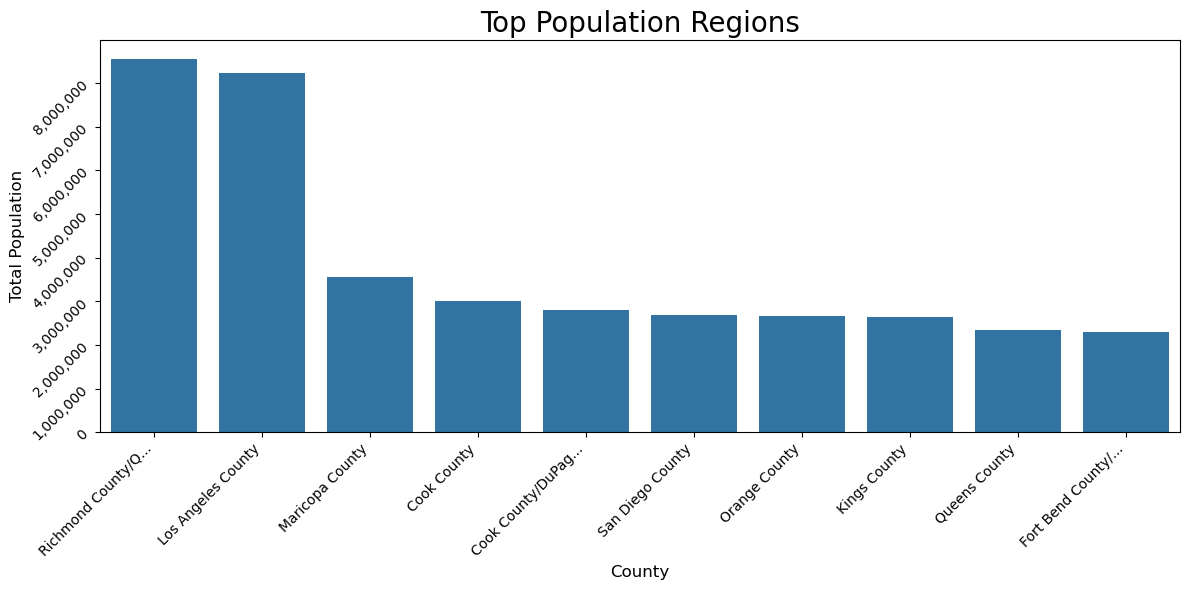

In [19]:
# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create a bar plot
sns.barplot(x='county', y='population', data=counties_grouped, errorbar=None, edgecolor='none')

# Add title and labels
plt.title('Top Population Regions', fontsize=20)
plt.xlabel('County', fontsize=12)
plt.ylabel('Total Population', fontsize=12)

# Format y-axis to show currency values more clearly
plt.ticklabel_format(style='plain', axis='y')

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Truncate x-axis labels if they're over 20 characters
labels = [label.get_text()[:17] + '...' if len(label.get_text()) > 20 else label.get_text() 
          for label in plt.gca().get_xticklabels()]
plt.gca().set_xticklabels(labels)

# Rotate x-axis and y-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

As you may expect, the largest counties coincide with the largest U.S. Cities. For example, Richmond County, Queens County, etc. represent New York City, and Los Angeles County represents Los Angeles. These are the two largest U.S. cities, and these provide a significant portion of their respective state's population.

In [20]:
sales_warehouse_year_df = sales_df[['Warehouse Code', 'Sales', 'Year']]

Let's group this by Warehouse Code, summing by Sales for each warehouse and year.

In [21]:
sales_grouped_warehouse_year = sales_warehouse_year_df.groupby(['Warehouse Code', 'Year'])['Sales'].sum().reset_index()
# print(sales_grouped_warehouse_year)

Let's visualize this with a grouped bar chart denoting Year on the x-axis and amount of Sales on the y-axis,
with each warehouse denoted by a different color bar.

In [22]:
counties_grouped_least = regions_df.groupby(['county', 'state'])['population'].sum().reset_index()
counties_grouped_least = counties_grouped_least.sort_values('population', ascending=True).head(10)
counties_grouped_least

,county,state,population
147,Floyd County,Indiana,50145
158,Galveston County,Texas,50180
411,Thurston County,Washington,50302
314,Ottawa County,Michigan,50340
51,Cache County,Utah,50371
241,Loudoun County,Virginia,51209
409,Tarrant County/Denton County/Dallas County,Texas,51404
168,Hall County,Nebraska,51440
55,Calhoun County,Michigan,51589
160,Garfield County,Oklahoma,51776


Insterestingly, the least populated counties served have no less than 50,000 residents. Presumably, 50,000 is the threshold for this company to determine feasibility of doing business in that county.

Now, let's prepare to create tables and visualizations comparing a state's population to its total sales.

First, let's group sales by state, summing sales and rounding to two (2) decimal places.

In [23]:
grouped_sales_state_all = sales_states_df.groupby('State')['Sales'].sum().reset_index()
grouped_sales_state_all['Sales'] = grouped_sales_state_all['Sales'].round(2)
# grouped_sales_state_all.head()

Then let's also group each state by population.

In [24]:
states_by_population_all = regions_df.groupby('state')['population'].sum().reset_index()
# states_by_population_all.head()

Let's create a new dataframe **states_sales_population**, where we can inner-merge these two separate state groupings together.

Then we'll clean this data by 
- Eliminating a duplicative State column (one came from each dataframe)
- Rename the 'population' column to 'Population' for consistency
- Add a 'Sales Per Person' column by diving 'Sales' by 'Population' for each 'State'.

In [25]:
states_sales_population = grouped_sales_state_all.merge(states_by_population_all,
                                                        left_on='State', right_on='state', how='inner')
states_sales_population = states_sales_population[['State', 'Sales','population']]
states_sales_population = states_sales_population.rename(columns={'population':'Population'})

states_sales_population['Sales Per Person'] = round(states_sales_population['Sales']/states_sales_population['Population'],2)

# states_sales_population

Let's create both a "best" list and a "worst" list of states, with ten (10) states each, by sorting this dataframe.

In [26]:
states_sales_population_best = states_sales_population.sort_values('Sales Per Person', ascending=False).head(10)
states_sales_population_worst = states_sales_population.sort_values('Sales Per Person', ascending=True).head(10)

Let's visualize the "best" states list to see which states get the most sales per person.

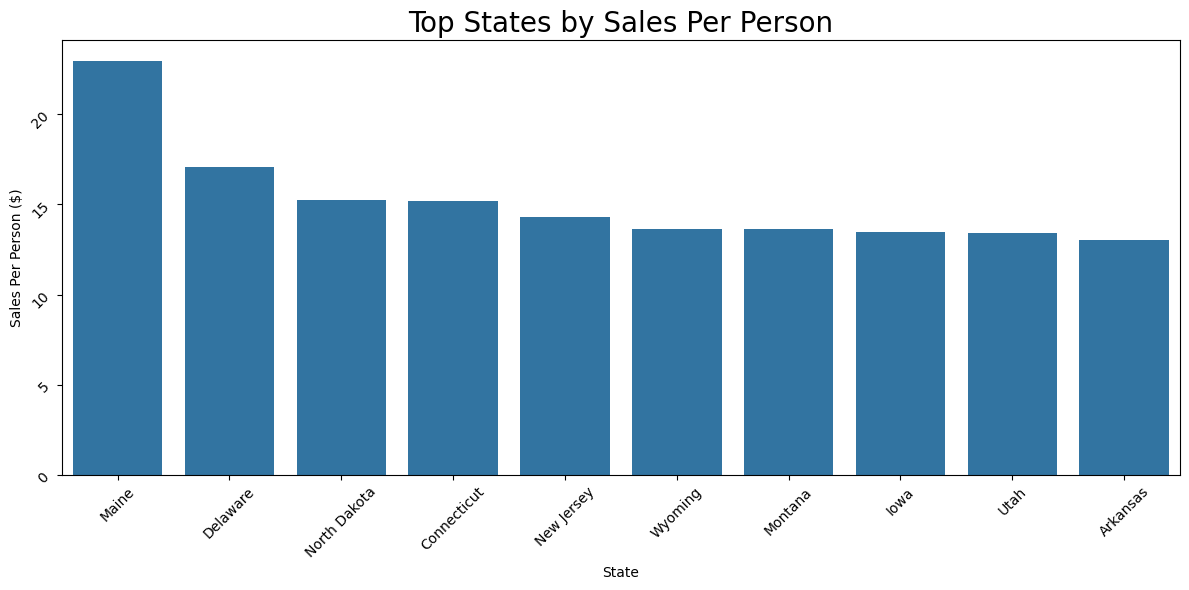

In [27]:
# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Convert the Series to a DataFrame if it's a Series
if isinstance(states_sales_population_best, pd.Series):
    # Reset the index to turn the index into a column
    states_sales_population_best = states_sales_population_best.reset_index()
    # Rename columns if needed - adjust these names to match your actual data
    states_sales_population_best.columns = ['State', 'Sales Per Person']

# Create a bar plot using seaborn for better aesthetics
ax = sns.barplot(x='State', y='Sales Per Person', data=states_sales_population_best)

# Add labels and title
plt.xlabel('State')
plt.ylabel('Sales Per Person ($)')
plt.title('Top States by Sales Per Person', fontsize=20)

# Rotate x-axis labels if there are many states
plt.xticks(rotation=45)

# Rotate y-axis labels as well
plt.yticks(rotation=45)

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

Let's recall our **states_by_population** dataframe and sort our ten (10) least populous states served and then visualize it.

In [28]:
states_by_population = regions_df.groupby('state')['population'].sum().reset_index()
states_by_population = states_by_population.sort_values('population', ascending=True).head(10)

Interestingly, none of the most populated states from earlier made this list. Could these be perhaps some of the least populated states, in terms of population served?

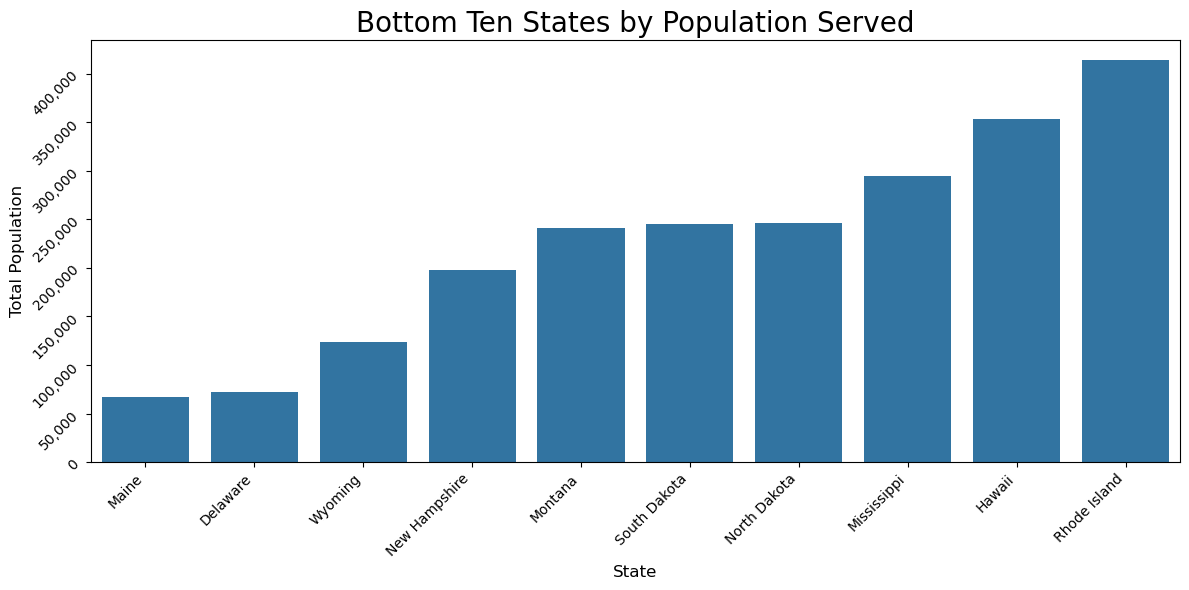

In [29]:
# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create a bar plot with the grouped data
# No error bars and no edge color
sns.barplot(x='state', y='population', data=states_by_population, errorbar=None, edgecolor='none')

# For older versions of seaborn (before v0.12.0), use this alternative:
# ax = sns.barplot(x='state', y='population', data=grouped_df, ci=None, edgecolor='none')

# Add title and labels
plt.title('Bottom Ten States by Population Served', fontsize=20)
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Population', fontsize=12)

# Tilt y-axis labels 45 degrees
plt.yticks(rotation=45)

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Rotate x-axis labels for better readability if there are many states
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Indeed, some of the states with the most sales per person also are the least-served states, namely Maine, North Dakota, Delaware, and Wyoming.

Let's create a dataframe excerpt from sales df with just the Warehouse Code and Sales.

In [30]:
sales_warehouse_df = sales_df[['Warehouse Code', 'Sales']]

Let's group this by Warehouse Code, summing by Sales for each warehouse.

Let's break this analysis down by year to see if the Sales by warehouse are consistent from year to year.
Let's create a dataframe excerpt from **sales_df** with just the Warehouse Code, Sales, and Year.

In [31]:
sales_grouped_warehouse = sales_warehouse_df.groupby('Warehouse Code')['Sales'].sum().reset_index()
# print(sales_grouped_warehouse)

Let's visualize this grouping with a simple bar chart to see how each warehouse performs.

Now let's see which customers constitute the most sales. That way we know that these customers are paramount to continued good business relations.

First, well inner-merge **sales_df** and **customers_df**

Now let's see which counties have the least population.

In [32]:
sales_customers_df = sales_df.merge(customers_df, 
           left_on='Customer Name Index', right_on='Customer Index', how='inner')

# sales_customers_df.head()

Next, we'll group these customers by Customer Name, summing their Sales, and sorting values descending. Then, we'll visualize this.

In [33]:
sales_grouped_customers = sales_customers_df.groupby('Customer Names')['Sales'].sum().reset_index()
sales_grouped_customers = sales_grouped_customers.sort_values('Sales', ascending=False).head(10)
sales_grouped_customers['Sales'] = sales_grouped_customers['Sales'].round(2)

# print(sales_grouped_customers)

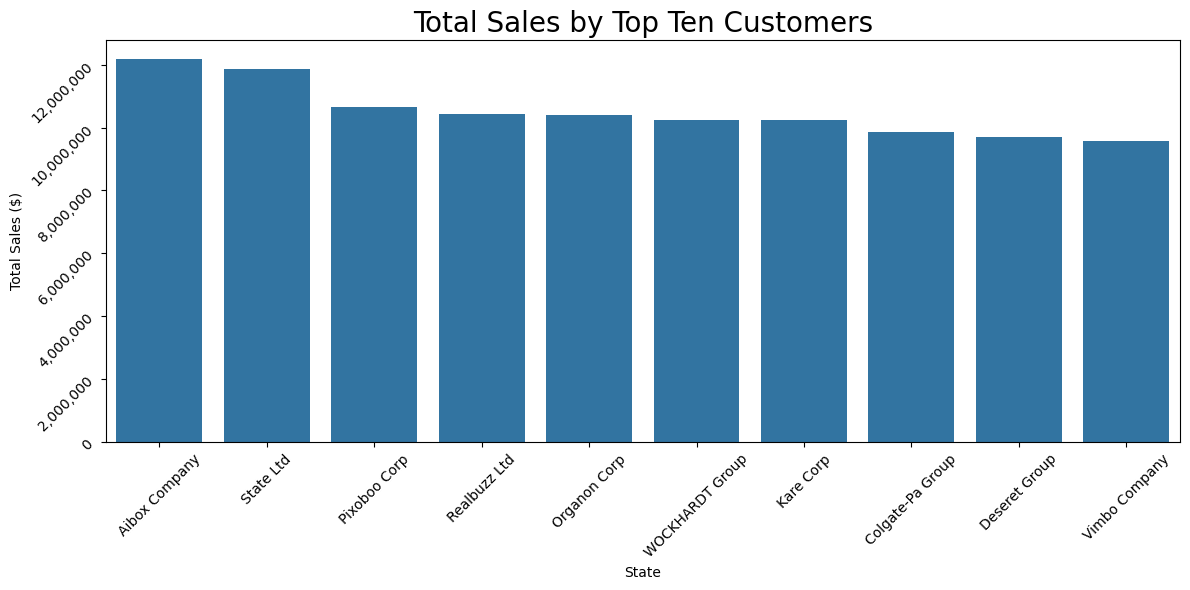

In [34]:
# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Convert the Series to a DataFrame if it's a Series
if isinstance(grouped_sales_state, pd.Series):
    # Reset the index to turn the index into a column
    grouped_sales_state = grouped_sales_state.reset_index()
    # Rename columns if needed - adjust these names to match your actual data
    grouped_sales_state.columns = ['Customer Names', 'Sales']

# Create a bar plot using seaborn for better aesthetics
ax = sns.barplot(x='Customer Names', y='Sales', data=sales_grouped_customers)

# Add labels and title
plt.xlabel('State')
plt.ylabel('Total Sales ($)')
plt.title('Total Sales by Top Ten Customers', fontsize=20)

# Rotate x-axis labels if there are many states
plt.xticks(rotation=45)

# Rotate y-axis labels as well
plt.yticks(rotation=45)

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

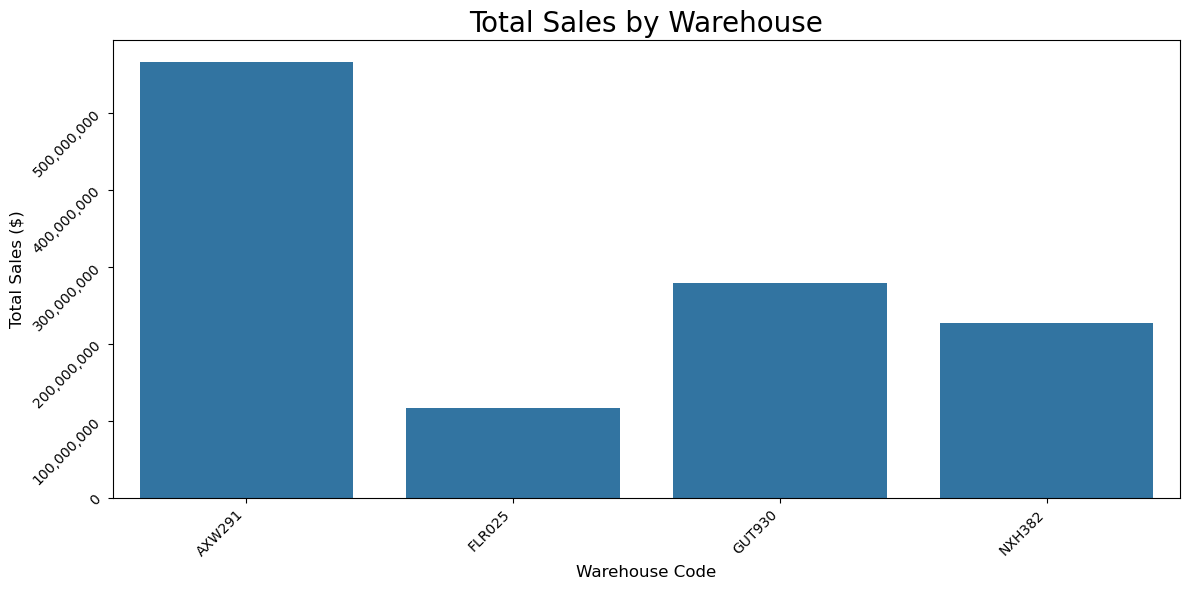

In [35]:
# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create a bar plot
sns.barplot(x='Warehouse Code', y='Sales', data=sales_grouped_warehouse, errorbar=None, edgecolor='none')

# Add title and labels
plt.title('Total Sales by Warehouse', fontsize=20)
plt.xlabel('Warehouse Code', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)

# Format y-axis to show currency values more clearly
plt.ticklabel_format(style='plain', axis='y')

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Rotate x-axis labels if there are many warehouse codes
plt.xticks(rotation=45, ha='right')

# Rotate y-axis labels as well
plt.yticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

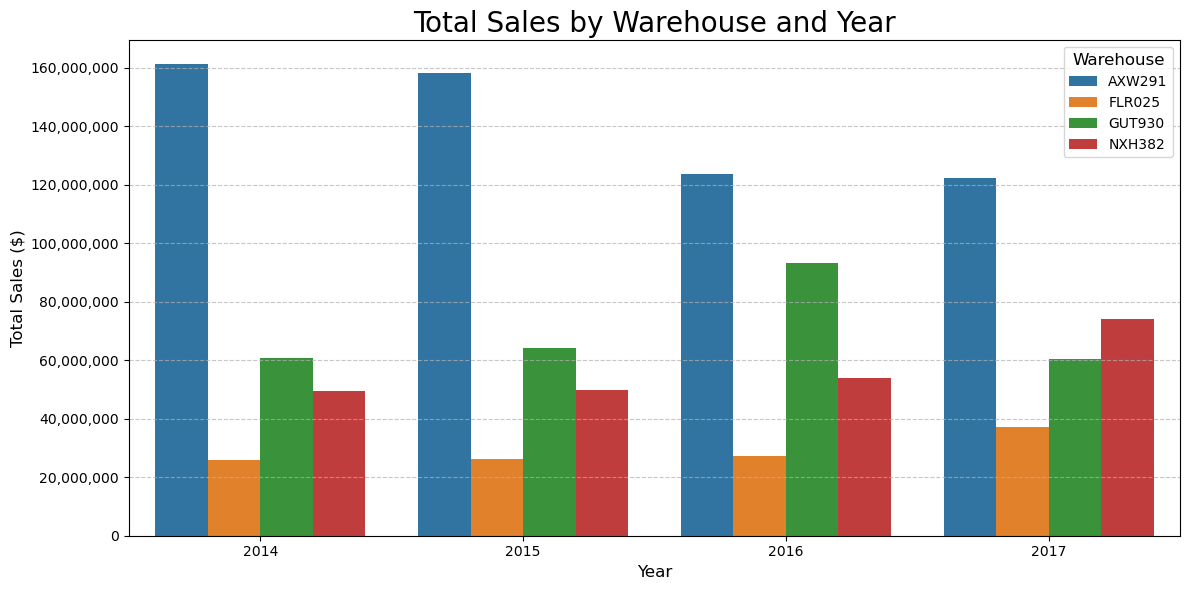

In [36]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create the grouped bar chart
# x-axis: Year, y-axis: Sales, groups: Region
sns.barplot(x='Year', y='Sales', hue='Warehouse Code', data=sales_grouped_warehouse_year)

# Add title and labels
plt.title('Total Sales by Warehouse and Year', fontsize=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Enhance the legend
plt.legend(title='Warehouse', title_fontsize=12)

# Add grid lines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

For 2014 and 2015, it looks like all warehouses are roughly the same for Sales, and also the same relative to each other. However, AXW291, who generated the majority of Sales in both years, decreases from 2016 onward, with each of the other warehouses generating a slightly larger portion of sales. Initially, GUT930, increases significantly in 2016, but decreases to previous levels in 2017 as NHX382 and FLR025 increase in sales.